 ## TP 5 : Markov chains & multithreading + _seaborn_

In [77]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### A. Useful tool for visualization: _seaborn_
_seaborn_ is a package designed for nice data and data analysis visualization.
See <http://seaborn.pydata.org/examples/> for examples of nice predefined graphics. Here is a way to represent the empirical distributions of 9 realizations of a bivariate random variable with normal distribution: 

<IPython.core.display.Javascript object>


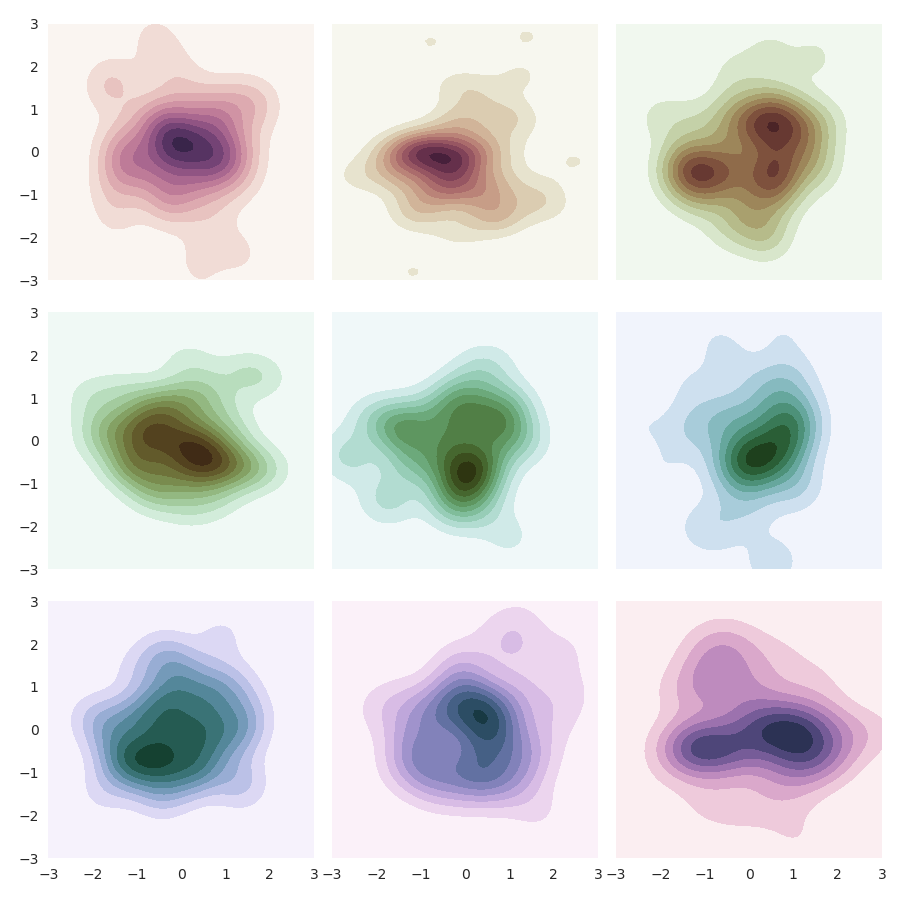

In [78]:
import seaborn as sns

sns.set(style="dark")
# RandomState : permet d'obtenir une suite de nombres aléatoires, mais qui restent toujours les mêmes lorsque l'on lance
# le programme plusieurs fois
rs = np.random.RandomState(50)

# Set up the matplotlib figure
# créé la figure et les axes (au nombre de 9 correspondant aux 9 figures)
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)


# Rotate the starting point around the cubehelix hue circle
# parcours des axes
# à chaque axe est associé un chiffre permettant ultérieurement de changer la couleur du graphe 
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    # créé la pallette de couleur pour un graphe (en fonction de s)
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    # génération de x et y suivant une loi normale 
    x, y = rs.randn(2, 50)
    
    # génération d'une estimation bivariante
    # prenant en compte la palette de couleur définie précédemment 
    # ainsi que les deux tableau de données (x et y)
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    
    #mise en forme des axes
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

#fonction de mise en forme
f.tight_layout()


### TO DO : 
**What is this example illustrating ?** (try to make each line of the code explicit, including the KDE method...)

## B. Simulation of Markov chains
Let ${(X_n)}_{n\geq 0}$ a Markov chain with values in a finite ensemble 
$E=\{x_1,\dots,x_N\}$ identified to $E=\{1,\dots,N\}$. The initial state is distributed according to:
$$
P(X_0 = k) = \rho_k,\qquad k=1\dots N.
$$
Let $A$ the transition matrix of this chain. We know that if $X_n = k$, the life time of the chain in this state obeys a geometrical law  with parameter $a_{kk}$. We also know that the probability of transition from  k to $\ell\neq k$
is given by:
$$
P(X_{n+1}=\ell | X_n=k, X_{n+1}\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

### One possible algorithm to simulate a Markov chain is therefore:

   a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.
   
   b. at instant $n$, knowing that $X_n=k$,
   
   i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.
   
   ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition.

1. Implement this algorithm in a function yielding `X = Markov(N,rho,A,nmax)` where:
    - N: number of states,
    - rho: law of the initial state (vector of size $N$ summing to 1),
    - A: transition matrix (of size $N\times N$),
    - nmax: number of time steps.

2. Make some simulations using simple Markov matrices (any positive matrix $A=(a_{k\ell})$ such that lines sum to 1) and represent their evolution.

3. Explore the potential of the `multiprocessing` package to implement a multithreaded version so that several Markov chains can be simulated in parallel.

See <https://docs.python.org/2/library/multiprocessing.html>

In [79]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [80]:
##### Functions to generate transition matrix and vectors of probabilities 

def generate_prob_array(n, threshold): 
    """
    Generates a vector of probabilities, which sums to 1.
    We generate a vector of uniform, and then sum everything and divide by the sum, such that the vector sums to 1.

    Parameters: 
    - n : number of elements of the vector
    - threshold : it is optional : put to 0 if we don't want to use it. Threshold puts some probabilities to 0.
    We use generate_prob_arrray later in order to generate a transition matrix (see generate_a, where we explain the
    usefulness of threshold)
    
    returns:
    - array : the vector of probabilites (size = n)
    """
    array=np.random.uniform(0,1,size=n)
    for i in range(n): 
        if (array[i]<threshold):
            array[i]=0
    res=np.sum(array)
    if (res<0.1):
        return generate_prob_array(n,threshold)
    array=array/res 
    return array




def generate_a(n, threshold = 0.4):
    """
    Generates a transition matrix
    
    Parameters : 
    - n : size of the transition matrix
    
    returns:
    - a : transition matrix of size n by n
    """
    
    
    a=np.zeros((n,n))
    for i in range(n):
        a[i]=generate_prob_array(n,threshold)
        # For each column of the transition matrix A, we generate a vector of probabilities. In the transition matrix,
        # we want to put some values of probablities to 0 (it makes the graph with less arrows so that the graph is less
        # messy.) Again, it is optional, we can put the threshold to 0 if we don't want the transition matrix to have
        # arbitrary elements equals to 0.
    return a

##### TESTS
n = 5

print("TEST generate_prob_array:")
threshold =0
rho = generate_prob_array(n,threshold)
print("- Example of probabilities vector rho :\n", rho,"\n" )

print("TEST generate_a:")
threshold = 0
A = generate_a(n,threshold)
print("- With threshold = ", threshold)
print("Example of transition matrix : \n", A, "\n")

threshold = 0.4
A = generate_a(n,threshold)
print("- With threshold = ", threshold)
print("Example of transition matrix :\n", A)





TEST generate_prob_array:
- Example of probabilities vector rho :
 [0.00492637 0.2270386  0.23147631 0.27127644 0.26528229] 

TEST generate_a:
- With threshold =  0
Example of transition matrix : 
 [[0.15136403 0.13420484 0.25394215 0.25259297 0.20789601]
 [0.20632844 0.005545   0.4449615  0.07737177 0.26579329]
 [0.29130929 0.08279374 0.04447956 0.15538306 0.42603435]
 [0.35577052 0.33253491 0.1813815  0.05419012 0.07612296]
 [0.00586393 0.29349991 0.29330355 0.04910396 0.35822865]] 

- With threshold =  0.4
Example of transition matrix :
 [[0.16030846 0.14418707 0.27571874 0.27197167 0.14781406]
 [0.16981875 0.25442904 0.23466527 0.34108694 0.        ]
 [0.1353383  0.30764853 0.         0.29278772 0.26422545]
 [0.         0.37380855 0.32052788 0.30566357 0.        ]
 [0.18526095 0.16921573 0.19352933 0.20698524 0.24500875]]


In [81]:
def choose_state(prob):
    """
    choose_state: 
    Sample from a distribution given by prob : P(X=i+1) = prob[i]
    
    Parameter:
    - prob : A vector containing a set of probabilities. prob sums to 1.
    
    Returns:
    - the sampled state i+1
    """
    
    i=0
    # génération d'un chiffre entre 0 et 1 suivant une loi uniforme
    choice = np.random.uniform(0,1)
    diff = prob[0]
    # si la valeur générée est inférieur à la variable diff on retourne i+1 (états compris entre 1 et N)

    while (choice>diff) : # la boucle s'arrêtera car choice <= 1 et la somme des éléments de prob = 1
        i += 1
        diff += prob[i]
    return i+1



#### TEST :
print("Vecteur de  probabilités rho : \n",rho)
nb_tir = 10
liste = np.zeros(nb_tir)
for i in range(nb_tir):
    liste[i] = choose_state(rho)

print("Nombres tirés selon rho : ", liste)

Vecteur de  probabilités rho : 
 [0.00492637 0.2270386  0.23147631 0.27127644 0.26528229]
Nombres tirés selon rho :  [3. 3. 2. 4. 3. 3. 5. 5. 5. 2.]


In [82]:
def life_time(akk) :
    """
    life_time: Assuming X = k and the probability to stay in this state is akk, T is the life time random variable.
    It's the time X stays in the state k.
    
    Parameter:
    - akk : Probability to stay in state k
    
    Returns:
    - T : a sample of the random variable T
    """
    
    T=0 
    # choose_state =1 ou 2, respectivement avec les probabilités akk ("on reste dans l'état k") 
    # et 1-akk ("on change d'état")
    while (choose_state([akk,1-akk])==1) : # Tant qu'on reste dans l'état k, on incrémente T
        T += 1
    return T # returns 0 if (X_i = k) and (X_{i+1} != k)




def next_transition(k,A) :
    """
    next_transition : Assuming we are in the state k, the function gives samples of :
    1) the time T during which we stay in state k
    2) the next state after T
    
    Parameters :
    - k : the current state k (X_i = k)
    - A : transition matrix
    
    Returns :
    - T : sample of the time we stay in state k (X_i = ... = X_{i+T} = k)
    - nextState : sample of the next state after T ie sample of X_{i+T+1}
    """
    # array_k : correspond à la kième ligne de la matrice de transition
    array_k = A[k-1]
    
    # T : temps passé dans l'état k
    T = life_time(array_k[k-1])  
    
    # prob-array : vecteur de probabilités qu'on passe à un état l, sachant qu'on est à k et qu'on ne reste pas à k
    prob_array = array_k/(1-array_k[k-1]) 
    prob_array[k-1] = 0 
    
    # on choisit le prochain état après avoir passé T temps à k
    nextState = choose_state(prob_array)
    return T,nextState



k=3
T, nextState = next_transition(k,A)

print("Transition matrix A : \n", A)
print("k =",k)
print("T = ", T, " , next_State = ", nextState)
print()

    


Transition matrix A : 
 [[0.16030846 0.14418707 0.27571874 0.27197167 0.14781406]
 [0.16981875 0.25442904 0.23466527 0.34108694 0.        ]
 [0.1353383  0.30764853 0.         0.29278772 0.26422545]
 [0.         0.37380855 0.32052788 0.30566357 0.        ]
 [0.18526095 0.16921573 0.19352933 0.20698524 0.24500875]]
k = 3
T =  0  , next_State =  1



In [83]:
def Markov(rho,A,nmax): 
    """
    Markov : gives a vector of states sampled from a Markov chain 
    
    parameters: 
    - rho : vector of probabilities for the initial state
    - A : transition matrix
    - nmax : number of time steps
    
    returns:
    - state : a vector of size nmax giving the list of the different states sampled
    """
    
    state = np.zeros(nmax)
    state[0] = choose_state(rho) # choose initial state
   
    i = 1 
    
    while (i<nmax): 
        T,nextState = next_transition(int(state[i-1]),A)
        # T : lifetime en étant à l'état state[i-1]. Ainsi, X_{i-1} = ... = X_{i-1+T} = state[i-1]
        # nextState: état après les T temps. Ainsi, X_{i+T} = nextState
        
        currentState = state[i-1]
        # currentState : état actuel, X_{i-1} = state[i-1]
        
        
        for t in range(T):
            state[min(i,nmax-1)] = currentState 
            # de i à i-1+T, l'état de X = currentState
            # si T est trop grand, tel que i-1+T dépasse nmax, le dernier état reste currentState
            #### A CHANGER AVEC UNE BOUCLE WHILE
            i +=1
            
        if i<=nmax-1: # Si on n'a pas dépassé le dernier élément de la liste state
            state[i] = nextState # On donne le prochain état
        i+=1
            
        #for j in range (T+1) :
        #    state[min(i,nmax-1)] = nextState
        #    i += 1
    return state

print("Example de chemin de Markov",Markov(rho,A,10))

Example de chemin de Markov [4. 2. 2. 2. 3. 4. 2. 1. 5. 5.]


## Display Markov graphs

In [84]:
# To use graphviz : install graphviz : see https://graphviz.gitlab.io/download/
# apt install graphviz on linux
# pip install graphviz

from graphviz import Digraph
from IPython.display import Image
def create_graph_node(A,pos):
    """
    Creates a graph, with a red node in one node wanted
    
    Parameters:
    - A : transition matrix
    - pos : the number of the node we want to put in red
    
    returns: 
    - graph : the graph
    """
    graph=Digraph(format='png')
    for i in range(len(A)): 
        if (i==pos-1): 
            graph.node(str(i+1),str(i+1),color='red') # creates a red node
        else : 
            graph.node(str(i+1),str(i+1)) # creates a black node
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                graph.edge(str(i+1),str(j+1),label = str(round(A[i,j],2))) # creates the edges
    return graph 



def create_graph_edge(A,pos1,pos2):
    """
    Creates a graph, with a green edge in one edge wanted to be green. The edge is defined by 2 nodes (arrow between 
    2 nodes)
    
    Parameters:
    - A : transition matrix
    - pos1 : position of initial node
    - pos2 : position of the node the green arrow points to
    
    returns: 
    - graph : the graph
    """
    graph=Digraph(format='png')
    for i in range(len(A)): 
        graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                if (i==pos1-1 and j==pos2-1):
                    graph.edge(str(i+1),str(j+1),color='green',label = str(round(A[i,j],2))) # creates the green edge
                else : 
                    graph.edge(str(i+1),str(j+1),label = str(round(A[i,j],2)))
    return graph

def display_graph(graph): 
    file=graph.render()
    display(Image(filename=file))

In [85]:
from IPython.display import clear_output
import time

def show_markov(path,time_sleep=0.8):
    """
    Displays graph of Markov
    
    Parameters:
    - path : Markov path we want to display the graph of
    
    """

    for i in range(len(path)-1):
        print("Chemin de Markov : ", path)
        display_graph(create_graph_node(A,path[i]))
        time.sleep(time_sleep) 
        clear_output()
        print("Chemin de Markov : ", path)
        display_graph(create_graph_edge(A,path[i],path[i+1]))
        time.sleep(time_sleep)
        clear_output()
    display_graph(create_graph_node(A,path[-1]))

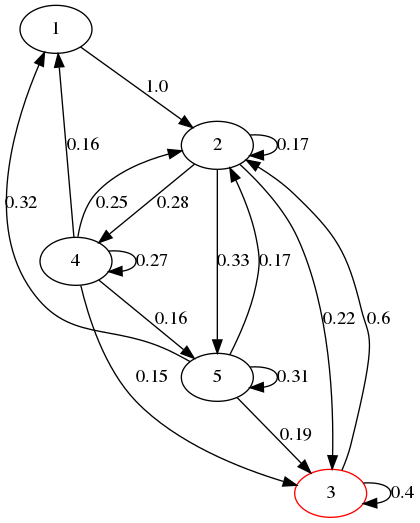

Chemin de Markov :  [4. 3. 2. 4. 2. 3. 2. 3. 2. 3.]


In [86]:
#### Display Markov graph

## Settings
time_sleep = 1 ### temps entre 2 noeuds rouges dans l'animation
threshold = 0.5 #### threshold is between 0 and 1, if it is to high, the transition matrix will be sparse. 
# if it is equal to 0, there won't be a lot of 0 elements in the transition matrix, so a lot of arrows in the graph,
# which makes it messy
number_states  = 5
nb_time_steps = 10 ## number of time steps


rho=generate_prob_array(number_states,0) # generates vector of probabilites for the initial state
A=generate_a(number_states, threshold)
markov_path = Markov (rho,A,nb_time_steps)

show_markov(markov_path,time_sleep)
print("Chemin de Markov : ", markov_path)


# Multiprocessing

In [87]:
from multiprocessing import Process
import time

In [88]:
### Multiprocessing

if __name__ == '__main__':
    start = time.time()
    # Generate 3 transitions matrix 
    A1 = generate_a(6)
    A2 = generate_a(6)
    A3 = generate_a(6)
    # Generate 3 vectors of probabilities for initial state
    rho1 = generate_prob_array(6,0)
    rho2 = generate_prob_array(6,0)
    rho3 = generate_prob_array(6,0)
    p1 = Process(target = Markov,args = (rho1,A1,10000)) # Markov chain avec 10000 time steps
    p2 = Process(target = Markov,args = (rho2,A2,10000))
    p3 = Process(target = Markov,args = (rho3,A3,10000))
    p1.start()
    p2.start()
    p3.start()
    p1.join()
    p2.join()
    p3.join()
    print("Temps avec multiprocessing",time.time()-start)

    
    
#### Sequantial 
start = time.time()
Markov(rho1,A1,10000)
Markov(rho2,A2,10000)
Markov(rho3,A3,10000)
print("Temps sans multiprocessing",time.time()-start)

Temps avec multiprocessing 0.07324385643005371
Temps sans multiprocessing 0.1582632064819336


Le temps avec multiprocessing est plus rapide.

In [89]:
from multiprocessing import Process
import time

# Multiprocessing
if __name__ == '__main__':
    start=time.time()
    # Generate 3 transitions matrix 
    A1 = generate_a(6)
    A2 = generate_a(6)
    A3 = generate_a(6)
    # Generate 3 vectors of probabilities for initial state
    rho1 = generate_prob_array(6,0)
    rho2 = generate_prob_array(6,0)
    rho3 = generate_prob_array(6,0)
    p1 = Process(target = Markov,args = (rho1,A1,1)) # Markov chain avec 1 seul time step
    p2 = Process(target = Markov,args = (rho2,A2,1))
    p3 = Process(target = Markov,args = (rho3,A3,1))
    p1.start()
    p2.start()
    p3.start()
    #time.sleep(5) # pour observer si les processus tournent bien en même temps
    p1.join()
    p2.join()
    p3.join()
    print("Temps avec multiprocessing",time.time()-start)

    
# Sequential
start = time.time()

Markov(rho1,A1,1)
Markov(rho2,A2,1)
Markov(rho3,A3,1)
print("Temps sans multiprocessing",time.time()-start)

Temps avec multiprocessing 0.0219728946685791
Temps sans multiprocessing 0.000217437744140625


Cette fois, comme les chemins sont plus courts (le cas limite est 1 seul time step), la simulation sans multiprocessing est plus rapide. Cela est intuitif car on prend du temps additionnel pour créer les processus, pour qu'ils communiquent avec la mémoire etc, alors qu'en les effectuant à la suite, il n'y a qu'une seule opération.

On peut voir les trois processus tourner sur le gestionnaire de processus.